# Experiment Playground
Use this notebook to train and evaluate models on any dataset discovered in `dataset/`.
Set the dataset and model identifiers in the cells below before running the training cell.

In [16]:
from pathlib import Path
import os
import sys
import pandas as pd
from IPython.display import display

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from core.config import load_training_config
from core.data import available_datasets, build_datasets
from core.train_eval import train_and_evaluate
from core.utils import setup_logging
from model import MODEL_REGISTRY

setup_logging()
CONFIG_PATH = PROJECT_ROOT / 'configs' / 'default.yaml'
BASE_CONFIG = load_training_config(CONFIG_PATH)
RUN_HISTORY = []


In [ ]:
dataset_names = available_datasets()
if not dataset_names:
    raise RuntimeError('No datasets found in dataset/.')
DATASET_NAME = dataset_names[1]  # change if you want a different dataset
print('Available datasets:', dataset_names)
print('Selected dataset:', DATASET_NAME)

Available datasets: ['fake-news-classification', 'fake-news-detection-datasets', 'llm-fake-news']
Selected dataset: fake-news-detection-datasets


In [11]:
third_data_path = "/Users/dorong/Desktop/hackerthonTA/fake-news-detection/dataset/fake-news-detection-datasets"
data3train = pd.read_csv(os.path.join(third_data_path, 'train.csv'))
data3test = pd.read_csv(os.path.join(third_data_path, 'test.csv'))
data3val = pd.read_csv(os.path.join(third_data_path, 'val.csv'))

print(len(data3train))
print(len(data3test))
print(len(data3val))

26938
8981
8979


In [13]:
fourth_data_path = "/Users/dorong/Desktop/hackerthonTA/fake-news-detection/dataset/llm-fake-news"
data4train = pd.read_csv(os.path.join(fourth_data_path, 'train.csv'))
data4test = pd.read_csv(os.path.join(fourth_data_path, 'test.csv'))
data4val = pd.read_csv(os.path.join(fourth_data_path, 'val.csv'))

print(len(data4train))
print(len(data4test))
print(len(data4val))

232003
38666
38666


In [11]:
MODEL_OPTIONS = list(MODEL_REGISTRY.keys())
MODEL_NAME = MODEL_OPTIONS[2]  # change to try other models
print('Available models:', MODEL_OPTIONS)
print('Selected model:', MODEL_NAME)
EPOCHS = 2  # feel free to increase once things run


Available models: ['bow_mlp', 'cnn_text', 'bilstm', 'tiny_transformer']
Selected model: bilstm


In [12]:
config = load_training_config(CONFIG_PATH, overrides={'epochs': EPOCHS})
loaders, vocab, tokenizer, info = build_datasets(
    name=DATASET_NAME,
    batch_size=config.batch_size,
    max_len=config.max_len,
    num_workers=config.num_workers,
    max_vocab_size=20000,
)
model_cls = MODEL_REGISTRY[MODEL_NAME]
model = model_cls(vocab_size=len(vocab), num_classes=2)
results, run_dir = train_and_evaluate(
    model,
    loaders,
    config,
    dataset_name=DATASET_NAME,
    model_name=MODEL_NAME,
    run_root=PROJECT_ROOT / 'runs',
)
RUN_HISTORY.append({'dataset': DATASET_NAME, 'model': MODEL_NAME, 'results': results, 'run_dir': str(run_dir)})
results


[2025-10-10 16:40:22] INFO fake_news: Starting training | dataset=fake-news-detection-datasets model=bilstm epochs=2 batch_size=64
[2025-10-10 16:40:36] INFO fake_news: Epoch 1 | train_loss=0.1104 val_loss=0.0024 val_f1=0.9993
[2025-10-10 16:40:51] INFO fake_news: Epoch 2 | train_loss=0.0052 val_loss=0.0012 val_f1=0.9998
[2025-10-10 16:41:01] INFO fake_news: Training complete | best_val_f1=0.9998 run_dir=/home/gamejoongsa/hackathon/runs/fake-news-detection-datasets/bilstm/20251010_074022


{'train': {'accuracy': 0.9996658994728637,
  'precision': 0.9996737984511883,
  'recall': 0.9996566440627783,
  'f1': 0.9996651865962032,
  'auroc': 0.9999577806649476,
  'loss': 0.001968211633749226},
 'val': {'accuracy': 0.999777258046553,
  'precision': 0.99977678580307,
  'recall': 0.99977678580307,
  'f1': 0.99977678580307,
  'auroc': 0.999999801123335,
  'loss': 0.001180805862987403},
 'test': {'accuracy': 0.999109230597929,
  'precision': 0.9991176683124665,
  'recall': 0.9990970804615935,
  'f1': 0.9991073245210828,
  'auroc': 0.9998260605782303,
  'loss': 0.004000036923826411}}

,accuracy,precision,recall,f1,auroc,loss
train,0.999666,0.999674,0.999657,0.999665,0.999958,0.001968
val,0.999777,0.999777,0.999777,0.999777,1.000000,0.001181
test,0.999109,0.999118,0.999097,0.999107,0.999826,0.004000


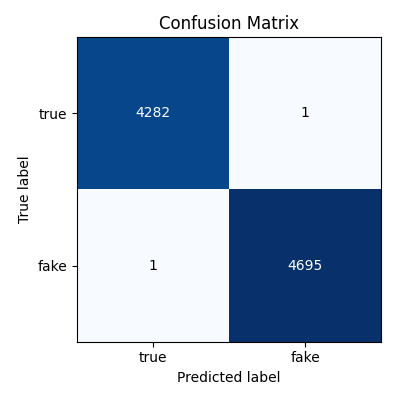

In [13]:
from IPython.display import Image
latest = RUN_HISTORY[-1]
metrics_df = pd.DataFrame(latest['results']).T
display(metrics_df)
cm_path = Path(latest['run_dir']) / 'confusion_matrix.png'
if cm_path.exists():
    display(Image(filename=str(cm_path)))
else:
    print('Confusion matrix not available for this run.')


In [14]:
summary_rows = []
for record in RUN_HISTORY:
    row = {
        'dataset': record['dataset'],
        'model': record['model'],
    }
    val_metrics = record['results'].get('val', {})
    for key, value in val_metrics.items():
        row[f'val_{key}'] = value
    summary_rows.append(row)
if summary_rows:
    display(pd.DataFrame(summary_rows))
else:
    print('Run the training cell to populate the summary.')


,dataset,model,val_accuracy,val_precision,val_recall,val_f1,val_auroc,val_loss
0,fake-news-detection-datasets,bow_mlp,0.979285,0.979164,0.979333,0.979245,0.997783,0.062230
1,fake-news-detection-datasets,cnn_text,1.000000,1.000000,1.000000,1.000000,1.000000,0.000615
2,fake-news-detection-datasets,bilstm,0.999777,0.999777,0.999777,0.999777,1.000000,0.001181
